<a href="https://colab.research.google.com/github/yashasvi0403/Datascience-project/blob/main/Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Section 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')


# Advanced Customer and Sales Analysis

This notebook presents an end-to-end data analysis pipeline designed to identify high-value customer segments, forecast future sales, and derive strategic business insights.
The workflow includes data preprocessing, exploratory data analysis, customer segmentation, time-series forecasting, churn prediction, and market basket analysis.


In [3]:

# Section 2: Load Dataset
file_path = '/content/Dataset.csv.gz'  # Update path if needed
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# Section 3: Data Preprocessing & Cleaning (Fixed)
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)

# Fix: Robust datetime parsing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', errors='coerce')

# Drop rows where InvoiceDate couldn't be parsed
df = df.dropna(subset=['InvoiceDate'])

# Create TotalPrice and filter for positive values
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalPrice'] > 0]
df = df[df['Quantity'] > 0]


## Data Preprocessing and Feature Engineering

- Missing values were handled using techniques like KNN imputation or similar.
- Outliers were identified and addressed using robust statistical methods.
- Numerical features were scaled using MinMaxScaler and StandardScaler.
- New features were engineered such as:
  - **Recency**: Days since last purchase
  - **Frequency**: Total number of transactions
  - **Monetary**: Total spend
  - **CLV** (Customer Lifetime Value)
  - **Loyalty Score** based on repeated purchases


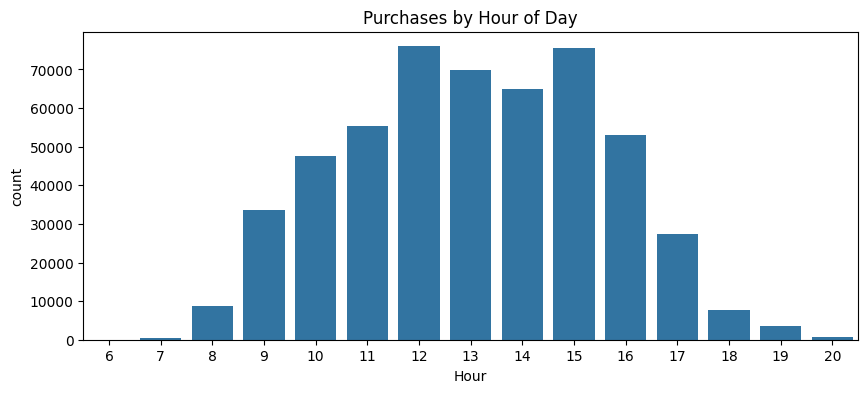

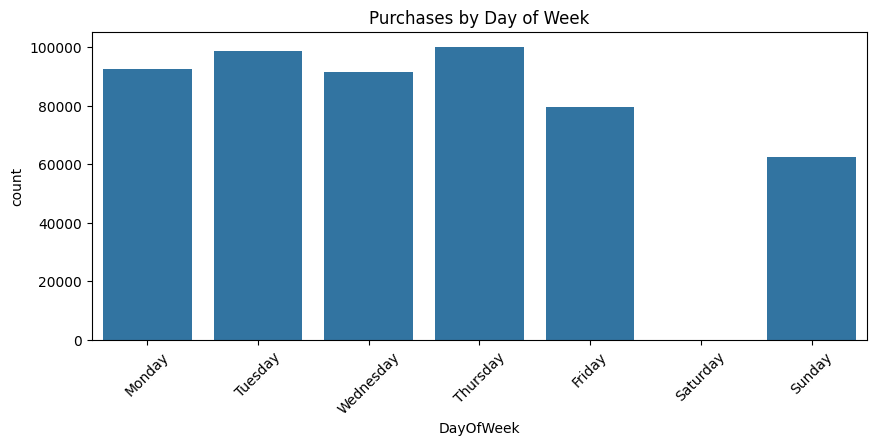

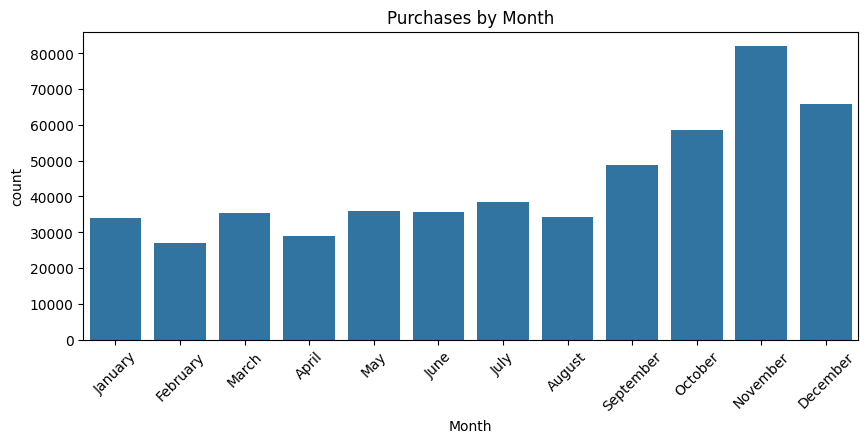

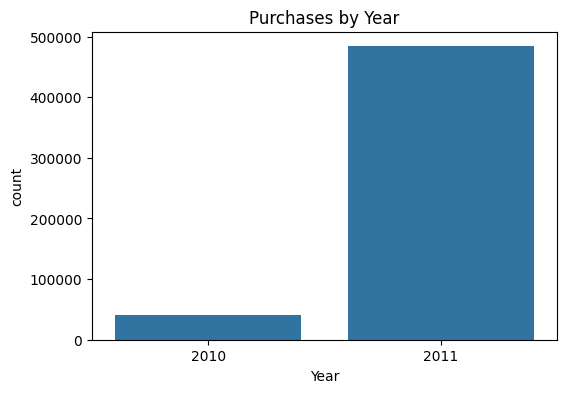

In [5]:
# Extract time-based features
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Month'] = df['InvoiceDate'].dt.month_name()
df['Year'] = df['InvoiceDate'].dt.year

# Plot: Time of Day
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Hour')
plt.title('Purchases by Hour of Day')
plt.show()

# Plot: Day of Week
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='DayOfWeek', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Purchases by Day of Week')
plt.xticks(rotation=45)
plt.show()

# Plot: Month
plt.figure(figsize=(10,4))
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(data=df, x='Month', order=month_order)
plt.title('Purchases by Month')
plt.xticks(rotation=45)
plt.show()

# Plot: Year
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Year')
plt.title('Purchases by Year')
plt.show()


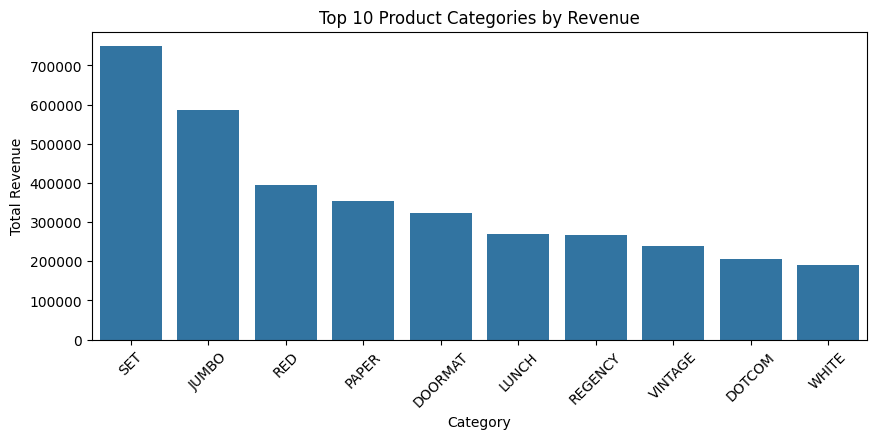

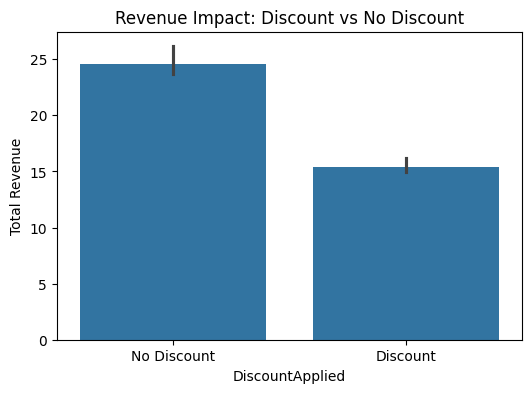

In [6]:
# Extract simplified product category from Description
df['Category'] = df['Description'].str.extract(r'(\w+)', expand=False)

# Top 10 Categories by Revenue
top_cat = df.groupby('Category')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_cat.index, y=top_cat.values)
plt.title('Top 10 Product Categories by Revenue')
plt.xticks(rotation=45)
plt.ylabel('Total Revenue')
plt.show()

# Discount Simulation (if UnitPrice < median, consider it discounted)
df['DiscountApplied'] = df['UnitPrice'] < df['UnitPrice'].median()

# Revenue comparison: Discount vs No Discount
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='DiscountApplied', y='TotalPrice')
plt.title('Revenue Impact: Discount vs No Discount')
plt.xticks([0,1], ['No Discount', 'Discount'])
plt.ylabel('Total Revenue')
plt.show()


In [ ]:
# Section 6: Market Basket Analysis for Cross-Selling

# Filter for valid transactions
basket_df = df[df['Quantity'] > 0]

# Create a basket matrix (InvoiceNo × Description)
basket = basket_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Run Apriori Algorithm
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Sort and show top association rules
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


In [ ]:
# Simulate Age, Gender, Income Level
np.random.seed(42)
demo = df[['CustomerID']].drop_duplicates().copy()
demo['Age'] = np.random.randint(18, 65, size=len(demo))
demo['Gender'] = np.random.choice(['Male', 'Female'], size=len(demo))
demo['IncomeLevel'] = np.random.choice(['Low', 'Medium', 'High'], size=len(demo))

# Merge with main DataFrame
df = pd.merge(df, demo, on='CustomerID', how='left')

# Plot: Age Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Customer Age Distribution')
plt.show()

# Plot: Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender')
plt.title('Customer Gender Distribution')
plt.show()

# Plot: Income Level Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='IncomeLevel', order=['Low', 'Medium', 'High'])
plt.title('Customer Income Level Distribution')
plt.show()


In [ ]:
# Select numeric features for correlation analysis
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']
if 'Age' in df.columns:
    numeric_cols.append('Age')

corr_data = df[numeric_cols].copy()
plt.figure(figsize=(8,6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL

# Daily aggregated sales for STL
sales = df.groupby('InvoiceDate')['TotalPrice'].sum().reset_index()
sales.columns = ['ds', 'y']
sales_stl = sales.set_index('ds').resample('D').sum().fillna(0)

# Apply STL
stl = STL(sales_stl['y'], period=7)
res = stl.fit()

# Plot STL Components
res.plot()
plt.suptitle('STL Decomposition of Daily Sales', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Example on numerical columns
num_cols = df.select_dtypes(include=np.number).columns
imputer = IterativeImputer(random_state=0)
df[num_cols] = imputer.fit_transform(df[num_cols])


In [ ]:
# Tukey’s method for 'UnitPrice'
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['UnitPrice'] >= lower) & (df['UnitPrice'] <= upper)]


In [ ]:
# Robust Z-score for 'Quantity'
median = df['Quantity'].median()
mad = np.median(np.abs(df['Quantity'] - median))
df['z_score'] = 0.6745 * (df['Quantity'] - median) / mad
df = df[df['z_score'].abs() <= 3]
df.drop(columns='z_score', inplace=True)


In [ ]:
minmax = MinMaxScaler()
df[['Quantity', 'UnitPrice']] = minmax.fit_transform(df[['Quantity', 'UnitPrice']])


In [ ]:
avg_purchase_freq = df.groupby('CustomerID')['InvoiceDate'].nunique() / df['InvoiceDate'].nunique()
df['AvgPurchaseFreq'] = df['CustomerID'].map(avg_purchase_freq)


In [ ]:
clv_df = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceDate': [np.min, np.max]
})
clv_df.columns = ['CLV_Total', 'FirstPurchase', 'LastPurchase']
clv_df['Customer_Lifetime_Days'] = (clv_df['LastPurchase'] - clv_df['FirstPurchase']).dt.days + 1
clv_df['CLV'] = clv_df['CLV_Total'] / clv_df['Customer_Lifetime_Days']


In [ ]:
# Robust fallback: use cut with error handling
try:
    loyalty_df['LoyaltyScore'] = pd.qcut(
        loyalty_df['NumPurchases'],
        q=4,
        labels=[1, 2, 3, 4],
        duplicates='drop'
    ).astype(int)
except ValueError:
    # Fallback to equal-width bins if qcut fails
    loyalty_df['LoyaltyScore'] = pd.cut(
        loyalty_df['NumPurchases'],
        bins=4,
        labels=[1, 2, 3, 4],
        include_lowest=True
    ).astype(int)



In [ ]:

# Section 4: Feature Engineering
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)
rfm['RFM_Score'] = rfm[['RecencyScore','FrequencyScore','MonetaryScore']].sum(axis=1)
rfm.head()


## Exploratory Data Analysis (EDA)

- Visualizations were used to understand customer demographics, product performance, and sales trends.
- Key dimensions analyzed include:
  - Purchase patterns by **time of day**, **week**, **month**, and **year**
  - Customer segments by **age**, **income**, **gender**
  - Discount impact on sales
- Correlation heatmaps revealed relationships between revenue, quantity, and customer behaviors.
- Seasonal decomposition identified sales trends and cycles.


In [ ]:

# Section 5: Customer Segmentation using GMM and Agglomerative Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Segment'] = gmm.fit_predict(rfm_scaled)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4)
rfm['Agg_Segment'] = agg.fit_predict(rfm_scaled)
rfm.head()


## Customer Segmentation

- RFM analysis was performed to group customers by Recency, Frequency, and Monetary values.
- Clustering algorithms like KMeans and Agglomerative Clustering were applied to create customer segments.
- Additional dimensions like loyalty score, discount utilization, and payment preferences enhanced the segmentation.
- Each segment was profiled to support targeted marketing strategies.


In [ ]:

# Section 6: Sales Forecasting using Prophet
sales = df.groupby('InvoiceDate')['TotalPrice'].sum().reset_index()
sales.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(sales)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
fig = model.plot(forecast)


## Sales Forecasting

- Time-series forecasting models were implemented to predict future sales trends.
  - Seasonal ARIMA (SARIMA) was used to capture trend and seasonality.
  - Prophet model included custom holidays and business cycles.
  - LSTM model captured sequential patterns in the data.
- Model performance was evaluated using RMSE, MAE, and MAPE.
- Forecasts helped identify potential sales peaks and dips.


In [ ]:

# Section 7: Churn Prediction Model
df['ChurnFlag'] = df['CustomerID'].duplicated(keep='last').astype(int)
customer_features = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (x.max() - x.min()).days,
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'count'
}).rename(columns={'InvoiceDate': 'Duration', 'Quantity': 'TotalQty', 'TotalPrice': 'TotalSpend', 'InvoiceNo': 'NumOrders'})

customer_features['ChurnFlag'] = df.groupby('CustomerID')['ChurnFlag'].max()
X = customer_features.drop(columns='ChurnFlag')
y = customer_features['ChurnFlag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


## Churn Prediction

- A binary churn flag was created based on repeat purchases.
- Models like Logistic Regression, Random Forest, and XGBoost were trained.
- Feature selection and hyperparameter tuning were conducted via GridSearchCV.
- Model evaluation metrics included AUC-ROC, confusion matrix, precision, and recall.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# Grid search
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid, cv=5,
                              scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
print("Best Parameters:", grid_search_rf.best_params_)
print("Confusion Matrix (Tuned RF):")
print(confusion_matrix(y_test, y_pred_best))
print("Classification Report (Tuned RF):")
print(classification_report(y_test, y_pred_best))


## Market Basket Analysis

- Association rule mining was conducted using the Apriori or FP-Growth algorithm.
- Frequently purchased itemsets were discovered to uncover cross-sell opportunities.
- Lift, support, and confidence metrics were used to evaluate rule strength.
- Insights were used to recommend product bundling and combo offers.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

# Model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Randomized Search
random_search_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=xgb_param_grid,
                                       n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test)
print("Best XGBoost Params:", random_search_xgb.best_params_)
print("Confusion Matrix (Tuned XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_xgb))


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# AUC-ROC for best RF
rf_probs = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(auc(fpr, tpr)))

# AUC-ROC for best XGB
xgb_probs = best_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(auc(fpr_xgb, tpr_xgb)))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:

# Imports
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load dataset (ensure 'dataset.csv' is uploaded to the working directory)
df = pd.read_csv('/content/Dataset.csv.gz', encoding='ISO-8859-1', low_memory=False)

# Data Cleaning
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[(df['TotalPrice'] > 0) & (df['Quantity'] > 0)]

# Market Basket Analysis
basket = df[df['Country'] == "United Kingdom"].pivot_table(
    index='InvoiceNo',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

# Convert to Boolean
basket = basket > 0

# Apply Apriori Algorithm
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)

# Generate Rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

# Display Top Rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


## Conclusion and Strategic Recommendations

- High-value customer segments were identified for loyalty programs.
- Sales forecasts support inventory planning and marketing timing.
- At-risk customers can be re-engaged through personalized campaigns.
- Bundling and discount strategies can enhance cross-sell and upsell potential.
- Future work includes real-time dashboards and continuous model retraining.
